# Results from the last two weeks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as inte
import scipy.interpolate as interpol
import scipy.optimize as opt

import axion_mass
import g_star
import eom
import density_plot
from config import plot_path, model, data_path
import runner
import potential
import qcd_axion_wkb

def array_map(f, xs): return np.array(list(map(f, xs)))

## Shellards $g_*$ Fit

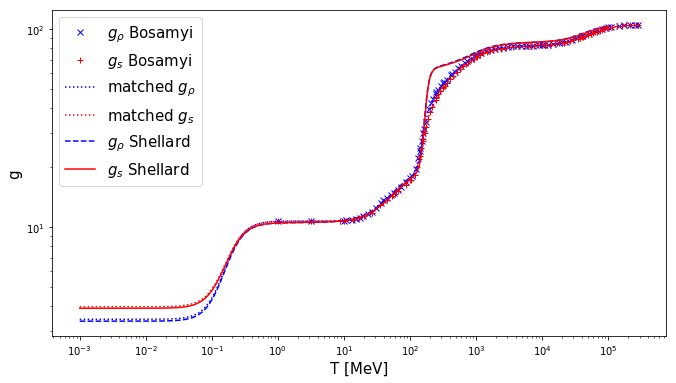

In [14]:
plt.figure(figsize=(11,6))
plot_type = plt.loglog
T = np.logspace(-6, 2, 400) * 1e9

plot_type(g_star.T_g_rho / 1e6, g_star.g_rho, "bx", label=r"$g_\rho$ Bosamyi")
plot_type(g_star.T_g_s / 1e6, g_star.g_s, "r+", label="$g_s$ Bosamyi")

plot_type(T / 1e6, list(map(g_star.matched.g_rho, T)), "b:", label=r"matched $g_\rho$")
plot_type(T / 1e6, list(map(g_star.matched.g_s, T)), "r:", label="matched $g_s$")

plot_type(T / 1e6, list(map(g_star.shellard_fit.g_rho, T)), "b--", label=r"$g_\rho$ Shellard")
plot_type(T / 1e6, list(map(g_star.shellard_fit.g_s, T)), "r-", label="$g_s$ Shellard")
plt.xlabel("T [MeV]", fontsize=15)
plt.ylabel("g", fontsize=15)
plt.legend(fontsize=15)

plt.savefig(plot_path + "/g_model_comparison.pdf")

## Neutrino Temperature

* Why use the ratio $g_R / g_s$? It also works just with $g_R$ or $g_s$.
* At higher temperatures, the assumption that $g_i = 2 (T_\gamma / T)^i + \frac{7}{8} 6 (T_\nu / T)^i$
  no longer holds, there we get a wrong result
* Constant ratio is valid after neutrino decoupling and $e^+ e^-$ Annihilation
  (Derivation in Kolb adn Turner as well as Mukanov)
* $T_\gamma = T_\nu$ for $T$ above neutrino decoupling

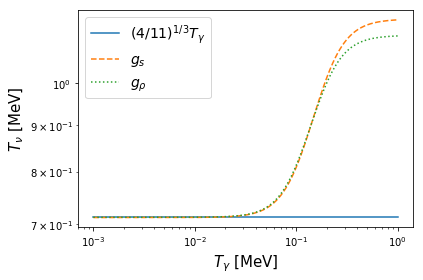

In [21]:
T = np.logspace(-3, 0, 400) * 1e6
plt.loglog(T / 1e6, (4 / 11)**(1/3) * np.ones(T.size), label=r"$(4/11)^{1/3} T_\gamma$")
plt.loglog(T / 1e6, (8*(array_map(g_star.shellard_fit.g_s, T) - 2) / (7*6))**(1/3), "--", label="$g_s$")
plt.loglog(T / 1e6, (8*(array_map(g_star.shellard_fit.g_rho, T) - 2) / (7*6))**(1/4), ":", label=r"$g_\rho$")
#plt.loglog(T / 1e6, array_map(find_T_neutrino, T), label="G")
#plt.loglog(T / 1e6, array_map(find_T_neutrino2, T), label="diff")
plt.xlabel(r"$T_\gamma$ [MeV]", fontsize=15)
plt.ylabel(r"$T_\nu$ [MeV]", fontsize=15)
plt.legend(fontsize=14)
plt.savefig(plot_path + "/neutrino_temperature.pdf")

## New Algorithm

New algorithm implemented including checking for $T_\mathrm{eq}$

## Corrected Results

In the paper by Bosamyi et al. $M_\mathrm{pl}$ is the normal Planck mass, not the reduced one.
$$
M_\mathrm{pl} = \frac{m_\mathrm{pl}}{\sqrt{8 \pi}}
$$
I used the reduced one (like in all other places) for their formulas $\Rightarrow$ Now corrected

In [2]:
Omega_a_h_sq_harm, theta_i_s_harm, f_a_s_harm = runner.load_data(data_path + "/harmonic.npz")
Omega_a_h_sq, theta_i_s, f_a_s = runner.load_data(data_path + "/cosine.npz")

/home/janik/Documents/bachelor/Code/density_plot.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(f_a / 1e9, theta_i, np.log10(Omega_a_h_sq))


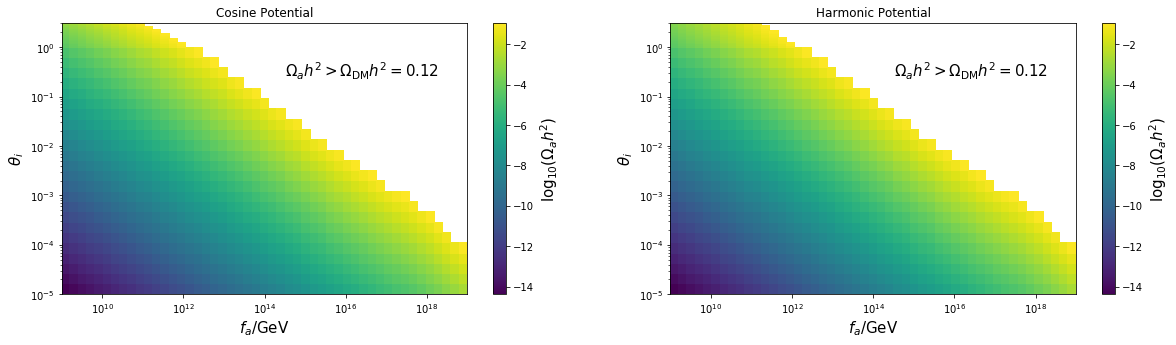

In [22]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title("Cosine Potential")
density_plot.plot_density(theta_i_s, f_a_s, Omega_a_h_sq, plot_type="pcolormesh")
plt.subplot(1,2,2)
plt.title("Harmonic Potential")
density_plot.plot_density(theta_i_s_harm, f_a_s_harm, Omega_a_h_sq_harm, plot_type="pcolormesh")
plt.savefig(plot_path + "/numerical_relic_density.pdf")

## Anharmonic Corrections

Numerical result matches the formula in the limits $\theta \rightarrow 0$ and $\theta \rightarrow \pi$.
It is larger in the intermediate range.

In [7]:
f = Omega_a_h_sq / Omega_a_h_sq_harm

Text(0,0.5,'f')

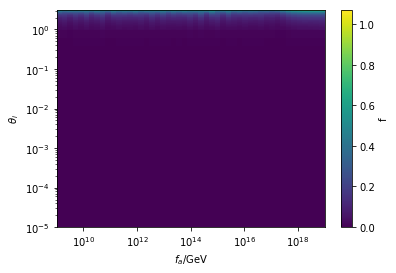

In [8]:
fig = plt.gcf()
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.pcolormesh(f_a_s / 1e9, theta_i_s, np.log10(f))
plt.xlabel(r"$f_a / \mathrm{GeV}$")
plt.ylabel(r"$\theta_i$")
cbar = plt.colorbar()
cbar.ax.set_ylabel("f")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


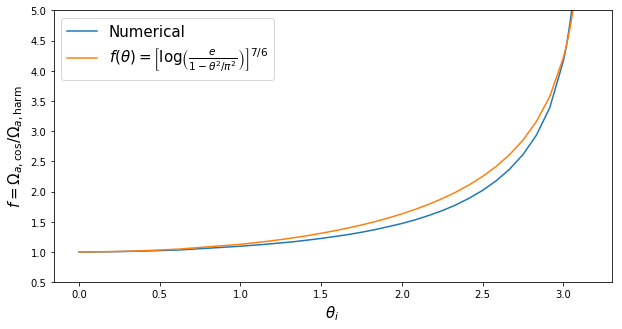

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0,0.5,'relative error')

/usr/local/lib/python3.6/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


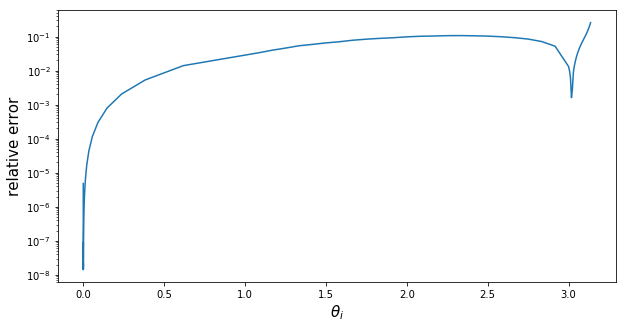

In [26]:
plt.figure(figsize=(10,5))
f_of_theta = inte.simps(f, f_a_s, axis=1) / (f_a_s[-1] - f_a_s[0])
f_of_theta_analytic = np.log(np.exp(1) / (1 - theta_i_s**2/np.pi**2))**(7/6)
plt.plot(theta_i_s, f_of_theta, "-", label="Numerical") 
plt.plot(theta_i_s, f_of_theta_analytic, 
         label=r"$f(\theta) = \left[\log\left(\frac{e}{1 - \theta^2 / \pi^2}\right)\right]^{7/6}$")
plt.xlabel(r"$\theta_i$", fontsize=15)
plt.ylabel(r"$f = \Omega_{a, \cos} / \Omega_{a, \mathrm{harm}}$", fontsize=15)
plt.ylim((0.5, 5))
plt.legend(fontsize=15)
plt.savefig(plot_path + "/anharmonic_corrections_plot.pdf")
plt.show()

plt.figure(figsize=(10,5))
plt.semilogy(theta_i_s, np.abs(f_of_theta - f_of_theta_analytic) / f_of_theta_analytic)
plt.xlabel(r"$\theta_i$", fontsize=15)
plt.ylabel("relative error", fontsize=15)


## Where is $\Omega_a = \Omega_\mathrm{DM}$?

Look good compared to the plot by Bosmanyi et al. except for the range where 
their plot becomes constant 

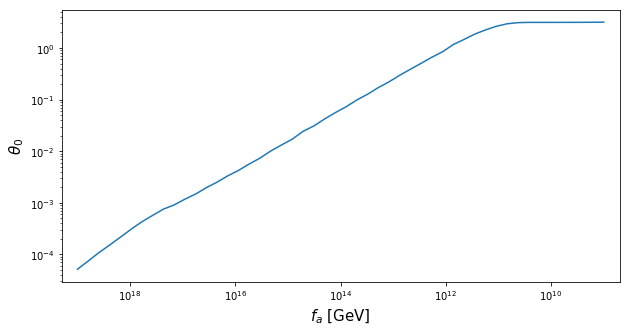

In [24]:
R_a = Omega_a_h_sq / model.Omega_DM_h_sq
R_a_avg = 1 / (theta_i_s[-1] - theta_i_s[0]) * inte.simps(R_a, theta_i_s, axis=0)

def solve_inital_theta(i, f_a):
    R_a_interp = interpol.interp1d(theta_i_s, R_a[:, i], bounds_error=False, fill_value="extrapolate")
    if f_a < 1e12 * 1e9:
        start = np.pi
    else:
        start = 1
    ans = opt.root(lambda theta: R_a_interp(theta) - 1.0, start).x[0]
    return ans

theta_0 = np.array([solve_inital_theta(i, f_a) for i, f_a in enumerate(f_a_s)])

plt.figure(figsize=(10,5))
plt.loglog(f_a_s / 1e9, theta_0, "-")
plt.xlim((np.min(f_a_s) / 1e9 / 2, 2 * np.max(f_a_s) / 1e9))
plt.gca().invert_xaxis()
plt.xlabel("$f_a$ [GeV]", fontsize=15)
plt.ylabel(r"$\theta_0$", fontsize=15)
plt.savefig(plot_path + "/initial_theta_for_DM.pdf")

### Plot from Bosamyi
![Plot from Bosamyi](bosamyi.png)

## Relative Error of the Analytic Result

Text(0,0.5,'$\\theta_i$')

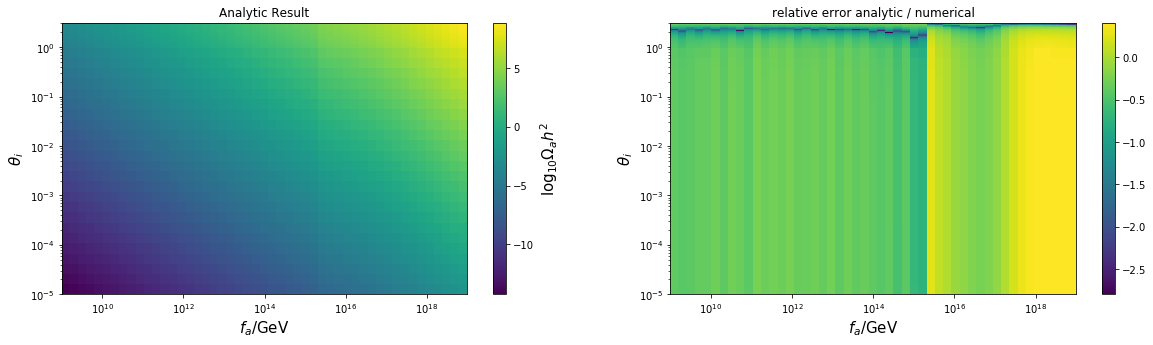

In [25]:
Omega_a_h_sq_analytic = qcd_axion_wkb.compute_analytic_relic_density(theta_i_s, f_a_s)
rel_err_analytic = np.abs(Omega_a_h_sq_analytic - Omega_a_h_sq) / Omega_a_h_sq 

plt.figure(figsize=(20,5))
fig = plt.gcf()

plt.subplot(1,2,1)
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.title("Analytic Result")
plt.pcolormesh(f_a_s / 1e9, theta_i_s, np.log10(Omega_a_h_sq_analytic))
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\log_{10} \Omega_a h^2$", fontsize=15)
plt.xlabel(r"$f_a / \mathrm{GeV}$", fontsize=15)
plt.ylabel(r"$\theta_i$", fontsize=15)

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.title("relative error analytic / numerical")
plt.pcolormesh(f_a_s / 1e9, theta_i_s, np.log10(np.abs(rel_err_analytic)))
#plt.pcolormesh(f_a_s / 1e9, theta_i_s, rel_err_analytic)

plt.colorbar()
plt.xlabel(r"$f_a / \mathrm{GeV}$", fontsize=15)
plt.ylabel(r"$\theta_i$", fontsize=15)